# Predicting the optimal location to set up a MMA gym in Santiago de Chile

## 1. Introduction

### 1.1. Background

Mixed martial arts, commonly known as MMA, is a term for the combat sport in which two competitors attempt to achieve dominance over one another by utilizing three general tactics: striking, finishing holds, and control. The rules allow the combatants to use a variety of martial arts, including punches, kicks, joint-locks, chokes, takedowns and throws, all of which incorporate techniques and theories from several sportive martial arts such as Amateur Wrestling, Submission Wrestling (usually Jiu-Jitsu), Kickboxing (usually Muay Thai), among others.

The sport has swept across the globe like a tidal wave in less than a generation, and today it is the world’s third most popular sport, behind soccer and basketball. There are 451 million people interested in MMA, according to Nielsen Sports DNA, (soccer has 901 million fans) and nearly 85% of the audience is outside the U.S., with one of its major audiences around the world in the neighboring country of Brazil.

### 1.2. Interest/Problem

Any businessman with an interest in sports, and with an eye for possible new trends in the market, would be highly interested in evaluating the scenario for setting up a new MMA gym in the populated city of Santiago de Chile. Though to make such a feat attainable, he would have to solve one of its biggest problems, and most likely, success defining factor: location, location, location. Therefore, a model backed by data that could shed some light on this problem would be particularly helpful for such an audience.

## 2. Data

The data to be used to solve the problem at hand will be mostly from two categories: demographics of Santiago de Chile, and the location and category of venues around the city. For the former, I will work with data collected by the government in the 2017 census, where they got all kinds of demographic features about the population, however, I will be working mainly with its age and gender data for each one of the boroughs in the city of Santiago. This data can be downloaded publicly from the following web page: http://resultados.censo2017.cl/. Now for the latter, I'll get the specifics about the different venues in each borough by leveraging the Foursquare API, and by looking at the relevant venues. (Sports, boxing, martial arts, etc.) To complement these datasets, and to further complete the analysis, I will scrape a Wikipedia page to get more information about the different boroughs in the city, so I can link the demographics with the venues properly. The web page to be scraped is the following: https://es.wikipedia.org/wiki/Anexo:Comunas_de_Chile. An important thing to be noted is that all the data is originally in Spanish, so it is important to keep in mind throughout the data wrangling process that the city's boroughs will normally be under "Comuna" or "Nombre comuna" names in the worked data, however I'll try to change everything to english along the process to make results clearer.

## 3. Methodology

### 3.1. Data wrangling

#### Let's import all the necessary libraries to complete this notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import requests
import folium
import re

#### Now let's scrape the Wikipedia page to get the data relative to each borough of the country, and then drop all the unnecessary columns and filter the boroughs so we keep only the ones in the city of Santiago

In [2]:
url = 'https://es.wikipedia.org/wiki/Anexo:Comunas_de_Chile'
table = pd.read_html(url)

In [3]:
boroughs = pd.DataFrame(table[0])
boroughs

,CUT (Código Único Territorial),Nombre,Unnamed: 2,Provincia,Región,Superficie(km²),Población2017,Densidad(hab./km²),IDH 2005,IDH 2005.1,Latitud,Longitud
0,15101,Arica,NaN,Arica,Arica y Parinacota,4799.4,221364,0.46,38.400,Alto,"-18°27'18""","-70°17'24"""
1,15102,Camarones,NaN,Arica,Arica y Parinacota,3927.0,1255,0.32,0.751,Alto,"-19°1'1.2""","-69°52'1.2"""
2,15201,Putre,NaN,Parinacota,Arica y Parinacota,5902.5,2765,0.47,0.707,Alto,"-18°12'0""","-69°34'58.8"""
3,15202,General Lagos,NaN,Parinacota,Arica y Parinacota,2244.4,684,0.31,0.670,Medio,"-17°39'10.8""","-69°38'6"""
4,1101,Iquique,NaN,Iquique,Tarapacá,2242.1,191468,85.40,0.766,Alto,"-20°14'38.4""","-70°8'20.4"""
...,...,...,...,...,...,...,...,...,...,...,...,...
341,13601,Talagante,NaN,Talagante,Metropolitana de Santiago,126.0,74237,589.20,0.749,Alto,"-33°40'1.2""","-70°55'51.6"""
342,13602,El Monte,NaN,Talagante,Metropolitana de Santiago,118.0,35923,304.40,0.688,Medio,"-33°41'2.4""","-71°1'1.2"""
343,13603,Isla de Maipo,NaN,Talagante,Metropolitana de Santiago,189.0,36219,191.60,0.724,Alto,"-33°45'14.4""","-70°53'9.6"""
344,13604,Padre Hurtado,NaN,Talagante,Metropolitana de Santiago,80.8,63250,782.80,0.728,Alto,"-33°34'33.6""","-70°47'60"""


In [4]:
columns_to_drop = ['CUT (Código Único Territorial)', 'Unnamed: 2', 'Región', 'IDH 2005.1']    
boroughs.drop(columns_to_drop, axis = 1, inplace=True)
boroughs

,Nombre,Provincia,Superficie(km²),Población2017,Densidad(hab./km²),IDH 2005,Latitud,Longitud
0,Arica,Arica,4799.4,221364,0.46,38.400,"-18°27'18""","-70°17'24"""
1,Camarones,Arica,3927.0,1255,0.32,0.751,"-19°1'1.2""","-69°52'1.2"""
2,Putre,Parinacota,5902.5,2765,0.47,0.707,"-18°12'0""","-69°34'58.8"""
3,General Lagos,Parinacota,2244.4,684,0.31,0.670,"-17°39'10.8""","-69°38'6"""
4,Iquique,Iquique,2242.1,191468,85.40,0.766,"-20°14'38.4""","-70°8'20.4"""
...,...,...,...,...,...,...,...,...
341,Talagante,Talagante,126.0,74237,589.20,0.749,"-33°40'1.2""","-70°55'51.6"""
342,El Monte,Talagante,118.0,35923,304.40,0.688,"-33°41'2.4""","-71°1'1.2"""
343,Isla de Maipo,Talagante,189.0,36219,191.60,0.724,"-33°45'14.4""","-70°53'9.6"""
344,Padre Hurtado,Talagante,80.8,63250,782.80,0.728,"-33°34'33.6""","-70°47'60"""


In [5]:
boroughs_santiago = boroughs.loc[boroughs['Provincia'] == 'Santiago']
boroughs_santiago.rename(columns={'Nombre': 'Comuna'}, inplace=True)
boroughs_santiago.reset_index(drop=True, inplace=True)
boroughs_santiago

,Comuna,Provincia,Superficie(km²),Población2017,Densidad(hab./km²),IDH 2005,Latitud,Longitud
0,Santiago,Santiago,23.2,404495,17435.1,0.807,"-33°26'14""","-70°39'26"""
1,Cerrillos,Santiago,21.0,80832,3849.1,0.743,"-33°30'0""","-70°43'0"""
2,Cerro Navia,Santiago,11.0,132622,12056.5,0.683,"-33°25'19.2""","-70°44'6"""
3,Conchalí,Santiago,10.7,126955,11865.0,0.707,"-33°22'48""","-70°40'30"""
4,El Bosque,Santiago,14.2,162505,11444.0,0.711,"-33°34'1.2""","-70°40'30"""
5,Estación Central,Santiago,15.0,147041,9802.7,0.735,"-33°27'32.4""","-70°41'56.4"""
6,Huechuraba,Santiago,44.8,98671,2202.5,0.737,"-33°22'4.8""","-70°38'2.4"""
7,Independencia,Santiago,7.0,100281,14325.9,0.709,"-33°24'46.8""","-70°39'57.6"""
8,La Cisterna,Santiago,10.0,90119,9011.9,0.775,"-33°31'44.4""","-70°39'46.8"""
9,La Florida,Santiago,70.2,366916,5226.7,0.804,"-33°31'30""","-70°32'16.8"""


#### Checking the data I realize that the latitude and longitude values are not in decimal form, (which will be required to make the call requests to the Foursquare API) so let's transform it using regular expresions and some simple math

In [6]:
for i in range(boroughs_santiago.shape[0]):
    ll_regex = re.compile(r'(-?)([0-9.]+)(°)([0-9.]+)(\')([0-9.]+)(")')
    #Let's transform the latitude values to decimal form
    lat = boroughs_santiago['Latitud'][i]
    lat_s = ll_regex.search(lat)
    if lat_s.group(1) == '-':
        boroughs_santiago['Latitud'][i] = lat_s.group(1) + str(float(lat_s.group(2)) + float(lat_s.group(4))/60 + float(lat_s.group(6))/3600)
    else:
        boroughs_santiago['Latitud'][i] = str(float(lat_s.group(2)) + float(lat_s.group(4))/60 + float(lat_s.group(6))/3600)
    #Now let's do the same with the longitude values
    lon = boroughs_santiago['Longitud'][i]
    lon_s = ll_regex.search(lon)
    if lon_s.group(1) == '-':
        boroughs_santiago['Longitud'][i] = lon_s.group(1) + str(float(lon_s.group(2)) + float(lon_s.group(4))/60 + float(lon_s.group(6))/3600)  
    else:
        boroughs_santiago['Longitud'][i] = str(float(lon_s.group(2)) + float(lon_s.group(4))/60 + float(lon_s.group(6))/3600)

boroughs_santiago

,Comuna,Provincia,Superficie(km²),Población2017,Densidad(hab./km²),IDH 2005,Latitud,Longitud
0,Santiago,Santiago,23.2,404495,17435.1,0.807,-33.43722222222222,-70.65722222222223
1,Cerrillos,Santiago,21.0,80832,3849.1,0.743,-33.5,-70.71666666666667
2,Cerro Navia,Santiago,11.0,132622,12056.5,0.683,-33.422,-70.735
3,Conchalí,Santiago,10.7,126955,11865.0,0.707,-33.38,-70.67500000000001
4,El Bosque,Santiago,14.2,162505,11444.0,0.711,-33.567,-70.67500000000001
5,Estación Central,Santiago,15.0,147041,9802.7,0.735,-33.459,-70.699
6,Huechuraba,Santiago,44.8,98671,2202.5,0.737,-33.368,-70.634
7,Independencia,Santiago,7.0,100281,14325.9,0.709,-33.413,-70.66600000000001
8,La Cisterna,Santiago,10.0,90119,9011.9,0.775,-33.528999999999996,-70.66300000000001
9,La Florida,Santiago,70.2,366916,5226.7,0.804,-33.525,-70.538


#### Cool. Now let's take a look at this data on a map. I'll use folium library to plot all the boroughs along with an estimated radius of influence of 1500 meters; that way we can get a sense of what areas we will be able to cover when extracting the venues information from the API.

In [7]:
boroughs_santiago['Latitud'] = boroughs_santiago['Latitud'].astype(float)
boroughs_santiago['Longitud'] = boroughs_santiago['Longitud'].astype(float)

r=1500 #radius in meters, for the area to be considered for each borough

santiago_comunas_map = folium.Map(location = [boroughs_santiago['Latitud'].mean(), boroughs_santiago['Longitud'].mean()], zoom_start=11.5)

for lat, lon, com in zip(boroughs_santiago['Latitud'], boroughs_santiago['Longitud'], boroughs_santiago['Comuna']):
    label = folium.Popup(com, parse_html=True)
    folium.Marker(
        location = [lat, lon],
        popup = com.encode('raw_unicode_escape'),
        tooltip = com.encode('raw_unicode_escape')).add_to(santiago_comunas_map) 
    folium.Circle(
        location = [lat, lon],
        radius = r,
        color = 'red').add_to(santiago_comunas_map)
santiago_comunas_map

#### That doesn't look too good... there ara too many areas overlapping and there is too much space uncovered. Hovering around the map and taking a quick look we can see that there are a couple of boroughs with the wrong latitude and longitude values, and that not all the boroughs have the same size, so they will require different radius values. With a couple of google searches let's manually change the wrong values, and let's also try a couple of different radius sizes based on what we just saw.

In [8]:
boroughs_santiago.loc[boroughs_santiago['Comuna'] == 'Pudahuel', 'Latitud'] = -33.4421
boroughs_santiago.loc[boroughs_santiago['Comuna'] == 'Pudahuel', 'Longitud'] = -70.7641

boroughs_santiago.loc[boroughs_santiago['Comuna'] == 'La Florida', 'Latitud'] = -33.5227
boroughs_santiago.loc[boroughs_santiago['Comuna'] == 'La Florida', 'Longitud'] = -70.5971

boroughs_santiago.loc[boroughs_santiago['Comuna'] == 'Pedro Aguirre Cerda', 'Latitud'] = -33.4941
boroughs_santiago.loc[boroughs_santiago['Comuna'] == 'Pedro Aguirre Cerda', 'Longitud'] = -70.6765

boroughs_santiago.loc[boroughs_santiago['Comuna'] == 'Vitacura', 'Latitud'] = -33.3905
boroughs_santiago.loc[boroughs_santiago['Comuna'] == 'Vitacura', 'Longitud'] = -70.5724

boroughs_santiago.loc[boroughs_santiago['Comuna'] == 'Santiago', 'Latitud'] = -33.4475

boroughs_santiago.loc[boroughs_santiago['Comuna'] == 'Ñuñoa', 'Longitud'] = -70.5960

boroughs_santiago.loc[boroughs_santiago['Comuna'] == 'San Ramón', 'Latitud'] = -33.5510
boroughs_santiago.loc[boroughs_santiago['Comuna'] == 'San Ramón', 'Longitud'] = -70.6464

boroughs_santiago.loc[boroughs_santiago['Comuna'] == 'San Joaquín', 'Latitud'] = -33.4999

boroughs_santiago.loc[boroughs_santiago['Comuna'] == 'Peñalolén', 'Longitud'] = -70.5528

boroughs_santiago.loc[boroughs_santiago['Comuna'] == 'Recoleta', 'Latitud'] = -33.400

santiago_comunas_map = folium.Map(location = [boroughs_santiago['Latitud'].mean(), boroughs_santiago['Longitud'].mean()], zoom_start=11.5)

for lat, lon, com in zip(boroughs_santiago['Latitud'], boroughs_santiago['Longitud'], boroughs_santiago['Comuna']):
    folium.Marker(
        location = [lat, lon],
        popup = com.encode('raw_unicode_escape'),
        tooltip = com.encode('raw_unicode_escape')).add_to(santiago_comunas_map) 

    if com in ['San Miguel', 'San Joaquín', 'La Cisterna']:
        r = 1100
    elif com in ['Lo Barnechea', 'La Reina', 'Peñalolén', 'Maipú', 'Santiago', 'Conchalí']:
        r = 2500
    else:
        r = 1500
    folium.Circle(
        location = [lat, lon],
        radius = r,
        color = 'red').add_to(santiago_comunas_map)

santiago_comunas_map

#### That looks way better. Now let's work on the demographics data. First I'm gonna read the excel data and then I'll drop all the unnecessary  data and filter again by the city of Santiago so I get the relevant boroughs. (On the "2.Data" section you can check where this data was downloaded from)

In [9]:
demographics = pd.read_excel('Demografia_chile.xlsx', sheet_name='COMUNAS', header=1)
demographics

,Unnamed: 0,ORDEN,NOMBRE REGIÓN,Código Región,NOMBRE PROVINCIA,Código Provincia,NOMBRE COMUNA,Código Comuna,Edad,Hombres,Mujeres,TOTAL
0,NaN,0,PAÍS,PAÍS,PAÍS,PAÍS,PAÍS,PAÍS,Total País,8601989.0,8972014.0,17574003.0
1,NaN,1,PAÍS,PAÍS,PAÍS,PAÍS,PAÍS,PAÍS,0 a 4,594059.0,572087.0,1166146.0
2,NaN,2,PAÍS,PAÍS,PAÍS,PAÍS,PAÍS,PAÍS,5 a 9,618121.0,592068.0,1210189.0
3,NaN,3,PAÍS,PAÍS,PAÍS,PAÍS,PAÍS,PAÍS,10 a 14,585855.0,561560.0,1147415.0
4,NaN,4,PAÍS,PAÍS,PAÍS,PAÍS,PAÍS,PAÍS,15 a 19,636064.0,608633.0,1244697.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7630,NaN,7630,MAGALLANES Y DE LA ANTÁRTICA CHILENA,12,ÚLTIMA ESPERANZA,124,TORRES DEL PAINE,12402,85 a 89,0.0,1.0,1.0
7631,NaN,7631,MAGALLANES Y DE LA ANTÁRTICA CHILENA,12,ÚLTIMA ESPERANZA,124,TORRES DEL PAINE,12402,90 a 94,0.0,0.0,0.0
7632,NaN,7632,MAGALLANES Y DE LA ANTÁRTICA CHILENA,12,ÚLTIMA ESPERANZA,124,TORRES DEL PAINE,12402,95 a 99,0.0,0.0,0.0
7633,NaN,7633,MAGALLANES Y DE LA ANTÁRTICA CHILENA,12,ÚLTIMA ESPERANZA,124,TORRES DEL PAINE,12402,100 o más,0.0,0.0,0.0


In [10]:
columns_to_drop =  ['Unnamed: 0', 'ORDEN', 'Código Región', 'Código Provincia', 'Código Comuna']
demographics.drop(columns_to_drop, axis=1, inplace=True)
demographics

,NOMBRE REGIÓN,NOMBRE PROVINCIA,NOMBRE COMUNA,Edad,Hombres,Mujeres,TOTAL
0,PAÍS,PAÍS,PAÍS,Total País,8601989.0,8972014.0,17574003.0
1,PAÍS,PAÍS,PAÍS,0 a 4,594059.0,572087.0,1166146.0
2,PAÍS,PAÍS,PAÍS,5 a 9,618121.0,592068.0,1210189.0
3,PAÍS,PAÍS,PAÍS,10 a 14,585855.0,561560.0,1147415.0
4,PAÍS,PAÍS,PAÍS,15 a 19,636064.0,608633.0,1244697.0
...,...,...,...,...,...,...,...
7630,MAGALLANES Y DE LA ANTÁRTICA CHILENA,ÚLTIMA ESPERANZA,TORRES DEL PAINE,85 a 89,0.0,1.0,1.0
7631,MAGALLANES Y DE LA ANTÁRTICA CHILENA,ÚLTIMA ESPERANZA,TORRES DEL PAINE,90 a 94,0.0,0.0,0.0
7632,MAGALLANES Y DE LA ANTÁRTICA CHILENA,ÚLTIMA ESPERANZA,TORRES DEL PAINE,95 a 99,0.0,0.0,0.0
7633,MAGALLANES Y DE LA ANTÁRTICA CHILENA,ÚLTIMA ESPERANZA,TORRES DEL PAINE,100 o más,0.0,0.0,0.0


In [11]:
demographics.drop(demographics[pd.isnull(demographics['NOMBRE COMUNA'])].index, axis=0, inplace=True)
demographics

,NOMBRE REGIÓN,NOMBRE PROVINCIA,NOMBRE COMUNA,Edad,Hombres,Mujeres,TOTAL
0,PAÍS,PAÍS,PAÍS,Total País,8601989.0,8972014.0,17574003.0
1,PAÍS,PAÍS,PAÍS,0 a 4,594059.0,572087.0,1166146.0
2,PAÍS,PAÍS,PAÍS,5 a 9,618121.0,592068.0,1210189.0
3,PAÍS,PAÍS,PAÍS,10 a 14,585855.0,561560.0,1147415.0
4,PAÍS,PAÍS,PAÍS,15 a 19,636064.0,608633.0,1244697.0
...,...,...,...,...,...,...,...
7629,MAGALLANES Y DE LA ANTÁRTICA CHILENA,ÚLTIMA ESPERANZA,TORRES DEL PAINE,80 a 84,2.0,2.0,4.0
7630,MAGALLANES Y DE LA ANTÁRTICA CHILENA,ÚLTIMA ESPERANZA,TORRES DEL PAINE,85 a 89,0.0,1.0,1.0
7631,MAGALLANES Y DE LA ANTÁRTICA CHILENA,ÚLTIMA ESPERANZA,TORRES DEL PAINE,90 a 94,0.0,0.0,0.0
7632,MAGALLANES Y DE LA ANTÁRTICA CHILENA,ÚLTIMA ESPERANZA,TORRES DEL PAINE,95 a 99,0.0,0.0,0.0


In [12]:
demographics_santiago = demographics.loc[demographics['NOMBRE PROVINCIA'] == 'SANTIAGO']
demographics_santiago.drop(labels=['NOMBRE REGIÓN', 'NOMBRE PROVINCIA'], axis=1, inplace=True)
demographics_santiago.rename(columns={'NOMBRE COMUNA':'Borough'}, inplace=True)
demographics_santiago.reset_index(drop=True, inplace=True)
demographics_santiago

,Borough,Edad,Hombres,Mujeres,TOTAL
0,SANTIAGO,Total Comunal,206678.0,197817.0,404495.0
1,SANTIAGO,0 a 4,10436.0,10181.0,20617.0
2,SANTIAGO,5 a 9,7881.0,7804.0,15685.0
3,SANTIAGO,10 a 14,6675.0,6323.0,12998.0
4,SANTIAGO,15 a 19,9104.0,8741.0,17845.0
...,...,...,...,...,...
699,VITACURA,80 a 84,792.0,1124.0,1916.0
700,VITACURA,85 a 89,536.0,841.0,1377.0
701,VITACURA,90 a 94,208.0,473.0,681.0
702,VITACURA,95 a 99,44.0,155.0,199.0


#### Ok so we've got 2 dataframes cleaned and ready. Now let's use the information cleaned in the first one about the boroughs to leverage the Foursquare API and get a dataframe with the venues information around the city. I'll only be retrieving the venues that fall in the "Athletics & Sports" category, since that is the only one we are interested in here. I'll also take into consideration the radius values that we defined earlier based on each borough, so that the results are as accurate as possible.

In [13]:
client_id = 'removed for sharing'
client_secret = 'removed for sharing'
version = '20201123'
limit = '100'
category = '4f4528bc4b90abdf24c9de85' #Athletics & Sports category

#### Perfect. Now that we got our last dataframe let's take a look to see if it requires any cleaning; let's see the different categories retrieved.

In [14]:
venues_list=[]

for lat, lon, com in zip(boroughs_santiago['Latitud'], boroughs_santiago['Longitud'], boroughs_santiago['Comuna']):
    if com in ['San Miguel', 'San Joaquín', 'La Cisterna']:
        radius = 1100
    elif com in ['Lo Barnechea', 'La Reina', 'Peñalolén', 'Maipú', 'Santiago', 'Conchalí']:
        radius = 2500
    else:
        radius = 1500

    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
        client_id,
        client_secret, 
        version, 
        lat, 
        lon,
        radius,
        limit,
        category)

    results = requests.get(url).json()["response"]['groups'][0]['items']

    for venue in results:
        venues_list.append((
            com,  
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

    venues_santiago = pd.DataFrame(venues_list, columns = ['Borough', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'])

venues_santiago

,Borough,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Santiago,Ludus Magnus Arena,-33.452331,-70.665440,Gym / Fitness Center
1,Santiago,Crossfit Yagan,-33.445030,-70.647068,Gym
2,Santiago,Pilates Qi,-33.438366,-70.643576,Yoga Studio
3,Santiago,Crossfighter,-33.452239,-70.646607,Gym / Fitness Center
4,Santiago,Gimnasio Entretiempo,-33.451329,-70.660673,Gym / Fitness Center
...,...,...,...,...,...
513,Vitacura,Tennis Balthus,-33.382551,-70.584836,Tennis Court
514,Vitacura,Club Estadio Croata - Canchas Voleyball Playa,-33.386789,-70.557487,Volleyball Court
515,Vitacura,Spa Mund,-33.398390,-70.575099,Spa
516,Vitacura,activefitchile,-33.388554,-70.564300,Gymnastics Gym


In [15]:
venues_categories = pd.DataFrame(venues_santiago['Venue Category'].unique(), columns=['Venues categories'])
print(venues_categories.shape)
venues_categories

(33, 1)


,Venues categories
0,Gym / Fitness Center
1,Gym
2,Yoga Studio
3,Plaza
4,Athletics & Sports
5,Building
6,Park
7,Residential Building (Apartment / Condo)
8,Soccer Field
9,Martial Arts School


#### Taking a quick glance, we can see that there are a couple of categories that don't seem to fit into what we are looking for. Let's take a closer look, and then drop/keep the ones relevant and update the dataframe.

In [16]:
categories_to_check = ['Plaza', 'Building', 'Park', 'Residential Building (Apartment / Condo)', 'Non-Profit', 'Spa', 'Hotel', 'Housing Development', 'Neighborhood', 'General Entertainment', 'Medical Center', 'Recreation Center', 'Tech Startup']

print(venues_santiago.loc[venues_santiago['Venue Category'].isin(categories_to_check)].shape)
venues_santiago.loc[venues_santiago['Venue Category'].isin(categories_to_check)]

(21, 5)


,Borough,Venue,Venue Latitude,Venue Longitude,Venue Category
8,Santiago,Plaza San Isidro,-33.448670,-70.643189,Plaza
11,Santiago,Edificio Palmas del Parque Almagro,-33.451083,-70.651302,Building
14,Santiago,Parque de los Reyes,-33.429436,-70.666230,Park
15,Santiago,Edificio General Jofre 67,-33.444469,-70.634399,Residential Building (Apartment / Condo)
22,Santiago,Santo Domingo Plaza,-33.436063,-70.654894,Residential Building (Apartment / Condo)
37,Santiago,Edificio Granados,-33.445538,-70.643228,Residential Building (Apartment / Condo)
42,Santiago,Geocentro Santa Victoria,-33.447633,-70.638964,Residential Building (Apartment / Condo)
47,Santiago,Edificio Santiago Oriente,-33.447251,-70.634372,Residential Building (Apartment / Condo)
65,Cerro Navia,Juventud para Cristo Chile,-33.417275,-70.745559,Non-Profit
172,La Reina,Plaza IV centenario,-33.424422,-70.546971,Plaza


In [17]:
categories_to_check.remove('Recreation Center')
print('The number of categories to finally remove is: ', len(categories_to_check))
categories_to_keep = [item for item in venues_categories.iloc[:,0] if item not in categories_to_check]
print('The number of categories to keep is: ', len(categories_to_keep))
categories_to_keep

The number of categories to finally remove is:  12
The number of categories to keep is:  24


['Gym / Fitness Center',
 'Gym',
 'Yoga Studio',
 'Athletics & Sports',
 'Soccer Field',
 'Martial Arts School',
 'Basketball Court',
 'Gymnastics Gym',
 'Skate Park',
 'Sports Club',
 'Tennis Court',
 'Soccer Stadium',
 'Skating Rink',
 'Other Great Outdoors',
 'College Gym',
 'Golf Course',
 'Pool',
 'College Track',
 'Track',
 'Volleyball Court',
 'Gym Pool',
 'Boxing Gym',
 'Hockey Field',
 'Climbing Gym']

In [18]:
venues_santiago_f = venues_santiago.loc[venues_santiago['Venue Category'].isin(categories_to_keep)]
venues_santiago_f.reset_index(drop=True, inplace=True)
venues_santiago_f

,Borough,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Santiago,Ludus Magnus Arena,-33.452331,-70.665440,Gym / Fitness Center
1,Santiago,Crossfit Yagan,-33.445030,-70.647068,Gym
2,Santiago,Pilates Qi,-33.438366,-70.643576,Yoga Studio
3,Santiago,Crossfighter,-33.452239,-70.646607,Gym / Fitness Center
4,Santiago,Gimnasio Entretiempo,-33.451329,-70.660673,Gym / Fitness Center
...,...,...,...,...,...
492,Vitacura,Yogaluka,-33.380587,-70.568884,Yoga Studio
493,Vitacura,Tennis Balthus,-33.382551,-70.584836,Tennis Court
494,Vitacura,Club Estadio Croata - Canchas Voleyball Playa,-33.386789,-70.557487,Volleyball Court
495,Vitacura,activefitchile,-33.388554,-70.564300,Gymnastics Gym


### 3.2. Analysis and visualizations

Now that we've got the dataframes with the relevant information, let's take a deeper look into them. We'll first look at the demographicss; according to Nielsen Sports: "MMA demographics skew young, with more than 40% of the audience 18 to 35.", so let's take that into account given that possible customers will most likely be young due to the physical conditions the sport requires. It should be noted that not only MMA fans would be a target, but also people who simply like individual disciplines, like boxing or jiu-jitsu. Also we will assume that men will be more inclined to the sport than women, so we will take that into account too. Let's first take a look at the different age ranges in the data and check the totals.

In [19]:
print(demographics_santiago['Edad'].unique())

['Total Comunal' '0 a 4' '5 a 9' '10 a 14' '15 a 19' '20 a 24' '25 a 29'
 '30 a 34' '35 a 39' '40 a 44' '45 a 49' '50 a 54' '55 a 59' '60 a 64'
 '65 a 69' '70 a 74' '75 a 79' '80 a 84' '85 a 89' '90 a 94' '95 a 99'
 '100 o más']


#### Ok, let's first take a look at the totals and the male proportion for each of the Boroughs.

In [20]:
demo_totals = demographics_santiago.loc[demographics_santiago['Edad'] == 'Total Comunal']
demo_totals.drop(labels='Edad', axis=1, inplace=True)
demo_totals['Male %'] = round(demo_totals['Hombres']/demo_totals['TOTAL']*100, 2) 
demo_totals.sort_values(by='Male %', ascending=False, inplace=True)
demo_totals.reset_index(drop=True, inplace=True)
demo_totals

,Borough,Hombres,Mujeres,TOTAL,Male %
0,SANTIAGO,206678.0,197817.0,404495.0,51.10
1,ESTACIÓN CENTRAL,73458.0,73583.0,147041.0,49.96
2,LO ESPEJO,49146.0,49658.0,98804.0,49.74
3,RENCA,72681.0,74470.0,147151.0,49.39
4,CERRO NAVIA,65438.0,67184.0,132622.0,49.34
5,SAN RAMÓN,40873.0,42027.0,82900.0,49.30
6,RECOLETA,77709.0,80142.0,157851.0,49.23
7,QUILICURA,103456.0,106954.0,210410.0,49.17
8,LA PINTANA,87044.0,90291.0,177335.0,49.08
9,INDEPENDENCIA,49186.0,51095.0,100281.0,49.05


Text(23, 48.866249999999994, '48.37')

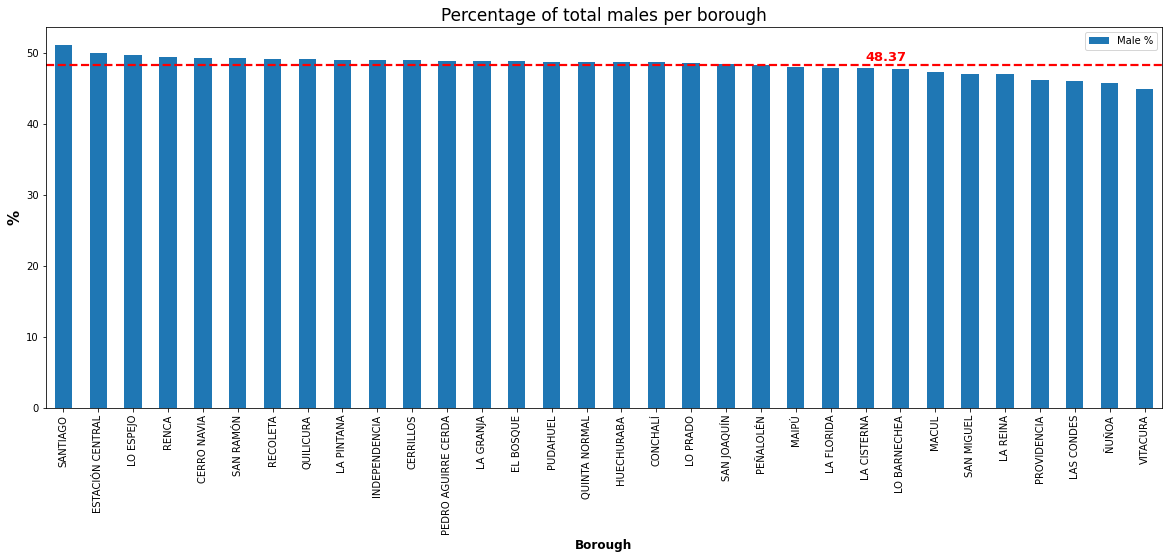

In [21]:
demo_totals[['Borough', 'Male %']].set_index('Borough').sort_values(by='Male %', ascending=False).plot(kind='bar', figsize=(20,7))

plt.title('Percentage of total males per borough', fontsize=17, fontweight='normal')
plt.xlabel('Borough', fontsize=12, fontweight='bold')
plt.ylabel('%', fontsize=15, fontweight='bold')
plt.axhline(y=demo_totals['Male %'].mean(), color='r', ls='--', lw='2.2', label='test')
plt.annotate(s=str(round(demo_totals['Male %'].mean(),2)), xy=(23,demo_totals['Male %'].mean()+0.5), c='r', weight='bold', fontsize=13)

In [22]:
print('The mean of the male\'s percentage per borough is:', demo_totals['Male %'].mean())
print('The standard deviation of the male\'s percentage per borough is:', demo_totals['Male %'].std())
print('The range of the male\'s percentage per borough is:', demo_totals['Male %'].max() - demo_totals['Male %'].min())
print('The interquartile range of the male\'s percentage per borough is:', np.percentile(demo_totals['Male %'],75) - np.percentile(demo_totals['Male %'],25))

The mean of the male's percentage per borough is: 48.366249999999994
The standard deviation of the male's percentage per borough is: 1.3021489682382241
The range of the male's percentage per borough is: 6.1200000000000045
The interquartile range of the male's percentage per borough is: 1.2625000000000028


#### Taking a glance at the bar graph, we can see that other than the first one,(Santiago) and the last four (Vitacura, Ñuñoa, Las Condes and Providencia) the difference between the boroughs is pretty much nothing. The standard deviation is at a quite low 1.3, and the interquartile range is only 1.26 %. The range is a little bit higher (6.12 %), due to the couple of boroughs at the extremes; but other than these, there isn't much of a difference here to consider. Let's now narrow the scope and take a look at the most relevant ages for our venture.

In [23]:
most_relevant_ages = ['15 a 19', '20 a 24', '25 a 29', '30 a 34', '35 a 39', '40 a 44']
demo_relevant_ages = demographics_santiago.loc[demographics_santiago['Edad'].isin(most_relevant_ages)]
demo_relevant_ages.reset_index(drop=True, inplace=True)
demo_relevant_ages

,Borough,Edad,Hombres,Mujeres,TOTAL
0,SANTIAGO,15 a 19,9104.0,8741.0,17845.0
1,SANTIAGO,20 a 24,21956.0,19661.0,41617.0
2,SANTIAGO,25 a 29,35378.0,31481.0,66859.0
3,SANTIAGO,30 a 34,32266.0,26278.0,58544.0
4,SANTIAGO,35 a 39,22274.0,18369.0,40643.0
...,...,...,...,...,...
187,VITACURA,20 a 24,2798.0,2961.0,5759.0
188,VITACURA,25 a 29,2653.0,2857.0,5510.0
189,VITACURA,30 a 34,2567.0,2993.0,5560.0
190,VITACURA,35 a 39,2752.0,3231.0,5983.0


In [24]:
summary_demo = demo_relevant_ages[['Borough', 'Hombres', 'Mujeres', 'TOTAL']].groupby(by='Borough', as_index=False).sum()
summary_demo.rename(columns={'TOTAL':'Total (15-44)'}, inplace=True)
summary_demo = summary_demo.merge(demo_totals[['Borough', 'TOTAL']], on='Borough')
summary_demo['Youth (15-44)%'] = round(summary_demo['Total (15-44)']/summary_demo['TOTAL']*100, 2)
summary_demo.sort_values(by='Youth (15-44)%', ascending=False, inplace=True)
summary_demo.reset_index(drop=True, inplace=True)
summary_demo

,Borough,Hombres,Mujeres,Total (15-44),TOTAL,Youth (15-44)%
0,SANTIAGO,136305.0,118247.0,254552.0,404495.0,62.93
1,INDEPENDENCIA,26947.0,25270.0,52217.0,100281.0,52.07
2,PROVIDENCIA,35654.0,37152.0,72806.0,142079.0,51.24
3,ESTACIÓN CENTRAL,38100.0,33881.0,71981.0,147041.0,48.95
4,QUILICURA,50916.0,51306.0,102222.0,210410.0,48.58
5,ÑUÑOA,48401.0,51370.0,99771.0,208237.0,47.91
6,SAN MIGUEL,25236.0,26408.0,51644.0,107954.0,47.84
7,RECOLETA,37589.0,35331.0,72920.0,157851.0,46.20
8,QUINTA NORMAL,25671.0,24811.0,50482.0,110026.0,45.88
9,PUDAHUEL,52604.0,52437.0,105041.0,230293.0,45.61


Text(23, 45.967187499999994, '45.47')

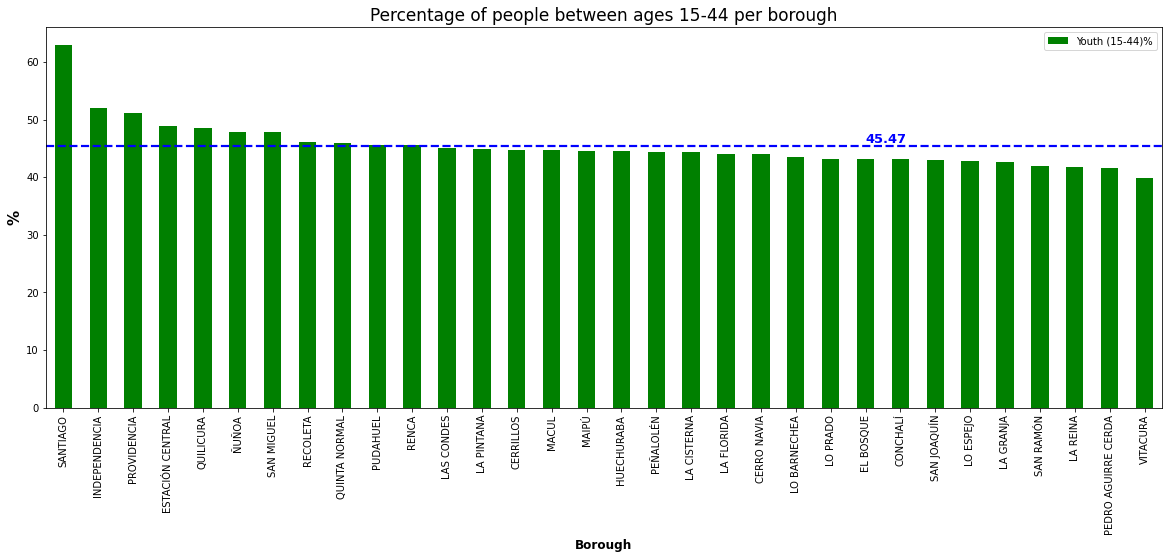

In [25]:
summary_demo[['Borough', 'Youth (15-44)%']].set_index('Borough').sort_values(by='Youth (15-44)%', ascending=False).plot(kind='bar', figsize=(20,7), color='g')

plt.title('Percentage of people between ages 15-44 per borough', fontsize=17, fontweight='normal')
plt.xlabel('Borough', fontsize=12, fontweight='bold')
plt.ylabel('%', fontsize=15, fontweight='bold')
plt.axhline(y=summary_demo['Youth (15-44)%'].mean(), color='b', ls='--', lw='2.2', label='test')
plt.annotate(s=str(round(summary_demo['Youth (15-44)%'].mean(),2)), xy=(23,summary_demo['Youth (15-44)%'].mean() + 0.5), c='b', weight='bold', fontsize=13)

In [26]:
print('The mean of the percentage of people between ages 15-44 per borough is:', summary_demo['Youth (15-44)%'].mean())
print('The standard deviation of the percentage of people between ages 15-44 per borough is:', summary_demo['Youth (15-44)%'].std())
print('The range of the percentage of people between ages 15-44 per borough is:', summary_demo['Youth (15-44)%'].max() - summary_demo['Youth (15-44)%'].min())
print('The interquartile range of the percentage of people between ages 15-44 per borough is:', np.percentile(summary_demo['Youth (15-44)%'], 75) - np.percentile(summary_demo['Youth (15-44)%'], 25))

The mean of the percentage of people between ages 15-44 per borough is: 45.467187499999994
The standard deviation of the percentage of people between ages 15-44 per borough is: 4.168264305265249
The range of the percentage of people between ages 15-44 per borough is: 23.060000000000002
The interquartile range of the percentage of people between ages 15-44 per borough is: 2.8075000000000117


#### Looking at this new bar graph we can easily see that the difference between the boroughs is greater than on the previous one, with the borough of Santiago towering over all the others again. The standard deviation is now at a big 4.16, while the range is at a huge 23.06%. The interquartile range however stood at a 2.81%, which shows that again most of the data at the middle ain't that different, although this time we see that the difference between the extremes is huge, with Santiago, Independia and Providencia on the top, and Vitacura, Pedro Aguirre Cerda, La Reina and San Ramón at the very bottom. Given this set of differences, let's further analyze the composition of this portion of the population, AKA "The Youth".

In [27]:
summary_demo['Male %(15-44)'] = round(summary_demo['Hombres']/summary_demo['Total (15-44)']*100,2)
summary_demo.sort_values(by='Male %(15-44)', ascending=False, inplace=True)
summary_demo.reset_index(drop=True, inplace=True)
summary_demo

,Borough,Hombres,Mujeres,Total (15-44),TOTAL,Youth (15-44)%,Male %(15-44)
0,SANTIAGO,136305.0,118247.0,254552.0,404495.0,62.93,53.55
1,ESTACIÓN CENTRAL,38100.0,33881.0,71981.0,147041.0,48.95,52.93
2,LO ESPEJO,21857.0,20473.0,42330.0,98804.0,42.84,51.63
3,INDEPENDENCIA,26947.0,25270.0,52217.0,100281.0,52.07,51.61
4,RECOLETA,37589.0,35331.0,72920.0,157851.0,46.20,51.55
5,PEDRO AGUIRRE CERDA,21623.0,20429.0,42052.0,101174.0,41.56,51.42
6,CONCHALÍ,27957.0,26761.0,54718.0,126955.0,43.10,51.09
7,LO PRADO,21244.0,20388.0,41632.0,96249.0,43.25,51.03
8,CERRO NAVIA,29746.0,28579.0,58325.0,132622.0,43.98,51.00
9,SAN RAMÓN,17734.0,17054.0,34788.0,82900.0,41.96,50.98


Text(23, 50.78749999999999, '50.29')

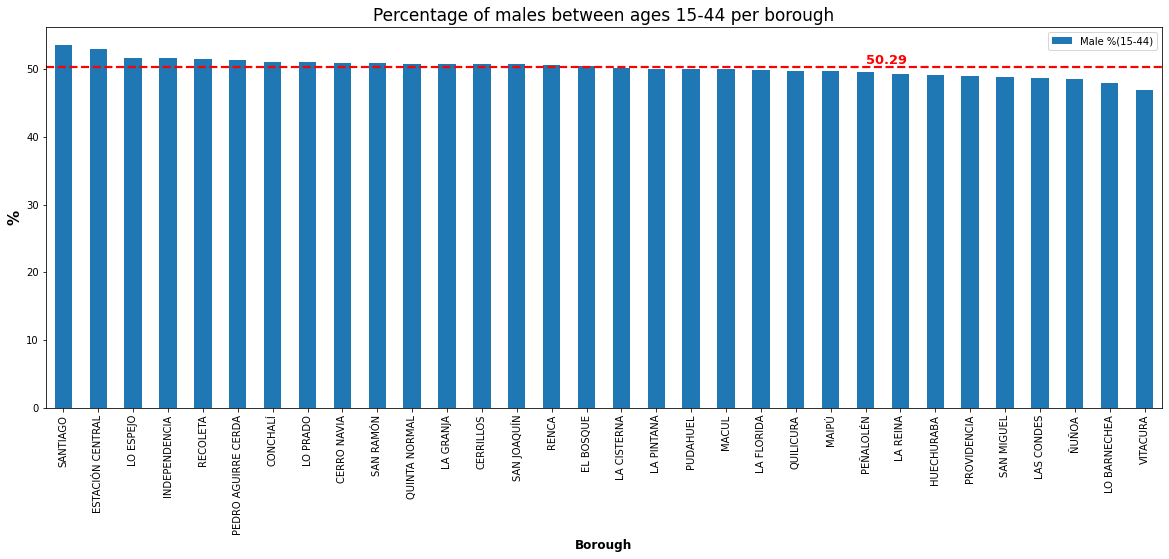

In [28]:
summary_demo[['Borough', 'Male %(15-44)']].set_index('Borough').sort_values(by='Male %(15-44)', ascending=False).plot(kind='bar',figsize=(20,7))

plt.title('Percentage of males between ages 15-44 per borough', fontsize=17, fontweight='normal')
plt.xlabel('Borough', fontsize=12, fontweight='bold')
plt.ylabel('%', fontsize=15, fontweight='bold')
plt.axhline(y=summary_demo['Male %(15-44)'].mean(), color='r', ls='--', lw='2.2', label='test')
plt.annotate(s=str(round(summary_demo['Male %(15-44)'].mean(),2)), xy=(23,summary_demo['Male %(15-44)'].mean() + 0.5), c='r', weight='bold', fontsize=13)

In [29]:
print('The mean of the male\'s percentage between ages 15-44 per borough is:', summary_demo['Male %(15-44)'].mean())
print('The standard deviation of the male\'s percentage between ages 15-44 per borough is:', summary_demo['Male %(15-44)'].std())
print('The range of the male\'s percentage between ages 15-44 per borough is:', summary_demo['Male %(15-44)'].max() - summary_demo['Male %(15-44)'].min())
print('The interquartile range of the male\'s percentage between ages 15-44 per borough is:', np.percentile(summary_demo['Male %(15-44)'], 75) - np.percentile(summary_demo['Male %(15-44)'], 25))

The mean of the male's percentage between ages 15-44 per borough is: 50.28749999999999
The standard deviation of the male's percentage between ages 15-44 per borough is: 1.351923361065097
The range of the male's percentage between ages 15-44 per borough is: 6.549999999999997
The interquartile range of the male's percentage between ages 15-44 per borough is: 1.480000000000004


#### After narrowing the population to only the "youth", we see that the male % didn't change much with respect to the totals. The first thing we notice is that the mean % went up by nearly 2%, and said increase reflected on pretty much all boroughs, so the overall differences between boroughs seemed to maintain. We see again Santiago and Estación Central at the top, and Vitacura remaining at the very bottom along with Lo Barnechea, showing a similar range of 6.55%. The standard deviation stood at a 1.35% and the interquartile range at a 1.48%, both of them showing nearly no difference among the central portion of boroughs. Let's now compare this three on a boxplot, to get a visual of all the differences we detected with the bar graphs.

{'whiskers': [<matplotlib.lines.Line2D at 0x217c9101d00>,
 'caps': [<matplotlib.lines.Line2D at 0x217c9133400>,
 'boxes': [<matplotlib.lines.Line2D at 0x217c91019a0>,
 'medians': [<matplotlib.lines.Line2D at 0x217c9133ac0>,
 'fliers': [<matplotlib.lines.Line2D at 0x217c9121160>,
 'means': [<matplotlib.lines.Line2D at 0x217c9133dc0>,
  <matplotlib.lines.Line2D at 0x217c91614f0>]}

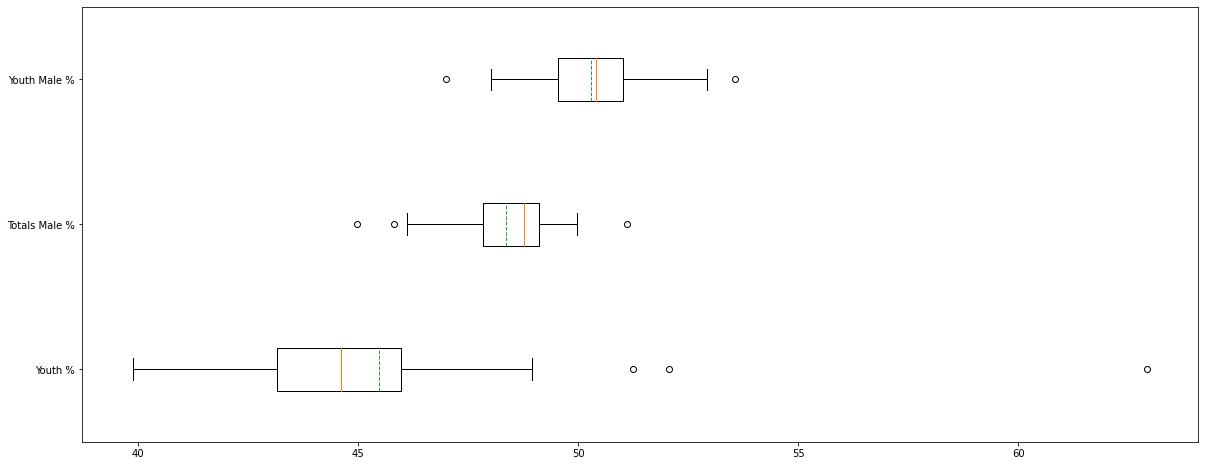

In [30]:
data = [summary_demo['Youth (15-44)%'], demo_totals['Male %'], summary_demo['Male %(15-44)']]

fig, ax = plt.subplots(figsize=(20,8))
ax.boxplot(data, vert=False, meanline=True, showmeans=True, labels=['Youth %','Totals Male %','Youth Male %'])

#### As said on the previous part, here it is even more obvious the differences between the three sets. The youth % is the one with the biggest variability, showing the bigger width between the whiskers, and the biggest box of all three; we also see that the three top boroughs were so far from the others, that they were considered as outliers, showing again that difference between the boroughs on this matter are quite significant. The other two sets seem to be more compact, with the Youth male % being bigger on average, and appearing to be better distributed, as it can be seen by the near match of the mean and the median (green and red line respectively), and the similar distance between the box and its whiskers. By this analysis, we can say that age is definitely a factor to considered due to the big differences it presents; however male % didn't seem to be that different throughout the boroughs, and other than the two extremes it wouldn't be a relevant factor on the final decision. Keeping this insights in mind, let's move on and look further into the venues. We'll first take a look at the most relevant venues (from the venues list previously extracted), and visualize them all on the map. 

In [31]:
most_relevant_venues = ['Martial Arts School', 'Boxing Gym']
print(venues_santiago_f.loc[venues_santiago_f['Venue Category'].isin(most_relevant_venues)].shape)
venues_santiago_f.loc[venues_santiago_f['Venue Category'].isin(most_relevant_venues)]

(23, 5)


,Borough,Venue,Venue Latitude,Venue Longitude,Venue Category
30,Santiago,Gimnasio Escuela: Acondicionamiento físico y T...,-33.450851,-70.633764,Martial Arts School
40,Santiago,Krav Maga Global,-33.449258,-70.650599,Martial Arts School
41,Santiago,Club De Boxeo Mexico,-33.435068,-70.659870,Martial Arts School
77,El Bosque,Taekwondo ATA Bouniot' s,-33.560979,-70.680110,Martial Arts School
85,Estación Central,Club De Judo Katsumoto,-33.462761,-70.698227,Martial Arts School
129,La Florida,Escuela De Karate Mario Castro,-33.522294,-70.584165,Martial Arts School
284,Maipú,Academia Choy Lee Fut Maipú,-33.529862,-70.775520,Martial Arts School
285,Maipú,Taekwondo ATA Martinez' Maipu,-33.503617,-70.752946,Martial Arts School
300,Ñuñoa,Santiago Budokan,-33.445498,-70.602813,Martial Arts School
306,Ñuñoa,Aikido Shinsen Dojo,-33.454501,-70.584818,Martial Arts School


In [32]:
Santiago_venues_map = folium.Map(location = [boroughs_santiago['Latitud'].mean(), boroughs_santiago['Longitud'].mean()], zoom_start=11.5)

for lat, lon, cat, ven in zip(venues_santiago_f['Venue Latitude'], venues_santiago_f['Venue Longitude'], venues_santiago_f['Venue Category'], venues_santiago_f['Venue']):
    if cat in most_relevant_venues:
        colors = 'red'
        fill = 1
    else:
        colors = 'blue'
        fill = 0.5

    folium.CircleMarker(
        location = [lat, lon],
        popup = ven,
        tooltip = cat,
        radius = 3,
        color= colors,
        fill = True,
        fill_opacity = fill).add_to(Santiago_venues_map)

Santiago_venues_map


#### At the previous map, most relevant venues can be seen on color red, while the rest of the sports related venues are on blue. Here we can get an space oriented idea of how this are distributed, and in which boroughs there is a lack of relevant venues, aswell as the neighboring boroughs conditions. There can also be seen which boroughs have a higher density of venues, which could translate into a bigger sport's market and better conditions to set up busisnesses. To further dig into this matters, let's add a column in the dataframe which accounts for the relevant venues, so we can group them up and keep crunching some numbers.

In [33]:
relevant = []

for i in range(venues_santiago_f.shape[0]):
    if venues_santiago_f['Venue Category'][i] in most_relevant_venues:
        relevant.append(True) 
    else:
        relevant.append(False)
venues_santiago_f['Relevant venues'] = relevant
venues_santiago_f

,Borough,Venue,Venue Latitude,Venue Longitude,Venue Category,Relevant venues
0,Santiago,Ludus Magnus Arena,-33.452331,-70.665440,Gym / Fitness Center,False
1,Santiago,Crossfit Yagan,-33.445030,-70.647068,Gym,False
2,Santiago,Pilates Qi,-33.438366,-70.643576,Yoga Studio,False
3,Santiago,Crossfighter,-33.452239,-70.646607,Gym / Fitness Center,False
4,Santiago,Gimnasio Entretiempo,-33.451329,-70.660673,Gym / Fitness Center,False
...,...,...,...,...,...,...
492,Vitacura,Yogaluka,-33.380587,-70.568884,Yoga Studio,False
493,Vitacura,Tennis Balthus,-33.382551,-70.584836,Tennis Court,False
494,Vitacura,Club Estadio Croata - Canchas Voleyball Playa,-33.386789,-70.557487,Volleyball Court,False
495,Vitacura,activefitchile,-33.388554,-70.564300,Gymnastics Gym,False


In [34]:
summary_venues = venues_santiago_f[['Borough', 'Venue', 'Relevant venues']].groupby(['Borough'], as_index=False).agg({'Venue':'count', 'Relevant venues':'sum'}).sort_values(by='Venue', ascending=False)
summary_venues['Relevant venues'] = summary_venues['Relevant venues'].astype(int)
summary_venues.reset_index(drop=True, inplace=True)
summary_venues

,Borough,Venue,Relevant venues
0,Providencia,51,8
1,Santiago,50,3
2,Vitacura,47,1
3,Las Condes,40,0
4,La Reina,36,0
5,Ñuñoa,33,3
6,Peñalolén,27,0
7,Lo Barnechea,23,0
8,Maipú,22,2
9,La Florida,22,1


#### Let's now merge this dataframe with the demographics one, to actually see if the amount of venues in each borough relates to its population; but first, we've got to transfrom de demographics borough's names so they match the ones in the venues dataframe.

In [35]:
summary_demo['Borough'] = summary_demo['Borough'].apply(lambda x: x.title())
summary_demo

,Borough,Hombres,Mujeres,Total (15-44),TOTAL,Youth (15-44)%,Male %(15-44)
0,Santiago,136305.0,118247.0,254552.0,404495.0,62.93,53.55
1,Estación Central,38100.0,33881.0,71981.0,147041.0,48.95,52.93
2,Lo Espejo,21857.0,20473.0,42330.0,98804.0,42.84,51.63
3,Independencia,26947.0,25270.0,52217.0,100281.0,52.07,51.61
4,Recoleta,37589.0,35331.0,72920.0,157851.0,46.20,51.55
5,Pedro Aguirre Cerda,21623.0,20429.0,42052.0,101174.0,41.56,51.42
6,Conchalí,27957.0,26761.0,54718.0,126955.0,43.10,51.09
7,Lo Prado,21244.0,20388.0,41632.0,96249.0,43.25,51.03
8,Cerro Navia,29746.0,28579.0,58325.0,132622.0,43.98,51.00
9,San Ramón,17734.0,17054.0,34788.0,82900.0,41.96,50.98


#### Cool. Now that our dataframes can be matched, let's merge them and then calculate the amount of venues per capita, and the amount of relevant venues per capita. As we previously saw on the demographics analysis, age is an important differentiaton factor, so from now on let's work with the relevant ages (15-44) data so we take those differences into account in the next analysis.

In [36]:
summary_venues = summary_venues.merge(summary_demo[['Borough', 'Total (15-44)']], on='Borough')
summary_venues['Venues per capita'] = summary_venues['Venue']/summary_venues['Total (15-44)']
summary_venues['Relevant venues per capita'] = summary_venues['Relevant venues']/summary_venues['Total (15-44)']
summary_venues.sort_values(by='Venues per capita', ascending=False, inplace=True)
summary_venues.reset_index(drop=True, inplace=True)
summary_venues

,Borough,Venue,Relevant venues,Total (15-44),Venues per capita,Relevant venues per capita
0,Vitacura,47,1,34046.0,0.001380,0.000029
1,La Reina,36,0,38717.0,0.000930,0.000000
2,Providencia,51,8,72806.0,0.000700,0.000110
3,Lo Barnechea,23,0,46064.0,0.000499,0.000000
4,Ñuñoa,33,3,99771.0,0.000331,0.000030
5,Las Condes,40,0,132936.0,0.000301,0.000000
6,Conchalí,14,0,54718.0,0.000256,0.000000
7,Peñalolén,27,0,107380.0,0.000251,0.000000
8,Macul,12,0,52045.0,0.000231,0.000000
9,La Cisterna,9,0,39965.0,0.000225,0.000000


#### This summary venues dataframe holds key information; here we can see the size of the sports market on each borough, and get a sense of which places would be better suited to develop a business in. We can also see which boroughs already have relevant venues, and how many, so we can get a sense of how much competition we would encounter, or on the other hand, which markets have openings to cover. All of this, taking into account the target population, which as we earlier defined would be the "youth" group. To help picturing this geospatially let's do a choropleth map visualization with the data. To correctly plot this information, we will have to eliminate any special characters in the boroughs names, (ó,í, ñ) so let's create a new dataframe with the updated data just for mapping purposes.

In [37]:
to_map = pd.DataFrame(columns=['Borough', 'Venues per capita', 'Relevant venues per capita'])

boroughs_special_d = {'Conchalí':'Conchali', 'Estación Central':'Estacion Central', 'Maipú':'Maipu', 'Ñuñoa':'Nunoa', 'Peñalolén':'Penalolen', 'San Joaquín':'San Joaquin', 'San Ramón':'San Ramon'}

for i in range(summary_venues.shape[0]):
    if summary_venues.iloc[i,0] not in boroughs_special_d.keys():
        to_map.loc[i] = [summary_venues.iloc[i,0], summary_venues.iloc[i,4], summary_venues.iloc[i,5]]
    else:
        to_map.loc[i] = [boroughs_special_d[summary_venues.iloc[i,0]], summary_venues.iloc[i,4], summary_venues.iloc[i,5]]

to_map.sort_values(by='Venues per capita', ascending=False)

,Borough,Venues per capita,Relevant venues per capita
0,Vitacura,0.001380,0.000029
1,La Reina,0.000930,0.000000
2,Providencia,0.000700,0.000110
3,Lo Barnechea,0.000499,0.000000
4,Nunoa,0.000331,0.000030
5,Las Condes,0.000301,0.000000
6,Conchali,0.000256,0.000000
7,Penalolen,0.000251,0.000000
8,Macul,0.000231,0.000000
9,La Cisterna,0.000225,0.000000


In [38]:
venues_per_capita_map = folium.Map(location=[-33.4489, -70.6693], zoom_start=11)

chile_geo = r'comunas_santiago.json'

folium.Choropleth(
    geo_data = chile_geo, 
    data = to_map, 
    columns = ['Borough', 'Venues per capita'],
    key_on = 'feature.properties.NOM_COM', 
    fill_color = 'YlGnBu', 
    legend_name = 'Venues per capita').add_to(venues_per_capita_map)

for lat, lon, com in zip(boroughs_santiago['Latitud'], boroughs_santiago['Longitud'], boroughs_santiago['Comuna']):
    folium.CircleMarker(
        location = [lat, lon],
        radius=2,
        color='black',
        fill=True,
        fill_opacity=1,
        popup = com.encode('raw_unicode_escape'),
        tooltip = com.encode('raw_unicode_escape')).add_to(venues_per_capita_map)

venues_per_capita_map

#### Here we can see the boroughs which have the most sports related venues per capita, and their relative locations regarding each other. We see that Vitacura has the greatest indicator per capita, followed with some distance by La Reina, and farther down by Providencia. We can also see that Lo Barnechea, Las Condes, Ñuñoa, San Joaquín and San Ramón, they all have have a slightly better per capita indicators than the rest of the venues, nevertheless they still seem pretty low in comparison to the top 3. This per capita indicator gives us a strong sense of which boroughs have a bigger sports market, showing not only people's preferences and habits, but also feasibility in terms of setting up this kind of shop. In general, we can see a trend where the east part of the city has the biggest market for sports venues. Let's now do a similar analysis but looking at the "Relevant venues per capita" rate, which could give us a hint of the competition in the different areas.

In [39]:
to_map.loc[to_map['Relevant venues per capita'] != 0.0].sort_values(by='Relevant venues per capita', ascending=True)

,Borough,Venues per capita,Relevant venues per capita
17,La Florida,0.000136,0.000006
22,Maipu,0.000095,0.000009
28,Quilicura,0.000068,0.000010
12,Santiago,0.000196,0.000012
13,Estacion Central,0.000167,0.000014
20,El Bosque,0.000100,0.000014
16,Renca,0.000149,0.000015
18,San Miguel,0.000136,0.000019
0,Vitacura,0.001380,0.000029
4,Nunoa,0.000331,0.000030


In [40]:
relevant_venues_per_capita_map = folium.Map(location=[-33.4489, -70.6693], zoom_start=11)

chile_geo = r'comunas_santiago.json'

folium.Choropleth(
    geo_data = chile_geo, 
    data = to_map.loc[to_map['Relevant venues per capita'] != 0.0], 
    columns = ['Borough', 'Relevant venues per capita'],
    key_on = 'feature.properties.NOM_COM', 
    fill_color = 'YlOrRd', 
    legend_name = 'Relevant venues per capita').add_to(relevant_venues_per_capita_map)

for lat, lon, com in zip(boroughs_santiago['Latitud'], boroughs_santiago['Longitud'], boroughs_santiago['Comuna']):
    if com in list(summary_venues.loc[summary_venues['Relevant venues per capita'] != 0.0, 'Borough']):
        folium.CircleMarker(
            location = [lat, lon],
            radius=2,
            color='black',
            fill=True,
            fill_opacity=1,
            popup = com.encode('raw_unicode_escape'),
            tooltip = com.encode('raw_unicode_escape')).add_to(relevant_venues_per_capita_map)

relevant_venues_per_capita_map

#### Here we see that there are only 12 boroughs that already have at least one "relevant venue" in it, with Providencia being the borough with the bigger amount of venues per capita. Other boroughs to highlight from this list would be San Ramón, Ñuñoa, Vitacura and San Joaquin. It is important to note that this indicator reflects on the amount of competition that there is on each bororugh, meaning that a higher indicator here is a bad sign, in contrast to the previous analysis on venues where a higher indicator meant a bigger market.

## 4. Discussion

On this section, any relevant issues concerning the study done will be discussed, along with any recommendations or caveats.

Regarding the area of incidence that was considered for each borough, it was seen that there were some areas that were not considered for this study, this is due to the fact that the calls to the API were made based on circular areas, and such areas can’t perfectly fit to cover the whole province while also respecting each borough’s boundaries. A better approach would be to used polygons to describe each borough; however, such requirements aren’t yet supported by the API. There is an alternative to use rectangles instead circles, but such approach would need the vertices coordinates, and those were not available for use.

Regarding the demographics, only age and gender were taken into account mainly for simplicity; however, even though socioeconomics were not directly addressed they still were implicitly considered on the last part of the analysis, when the amount of venues per borough was used as an indicator of better markets to invest in. This fact, will positively correlate to the economic health of both the borough and its population.

As for the venues, all sports related venues were considered in the study due to the assumption that an MMA gym could be a substitute product for any other kind of sport. Any correlation between different sports audience/enthusiasts’ preferences was not taken into account, mainly because such consideration would highly increase the complexity of the study without bringing that much of a difference. Moreover, when analyzing the different boroughs regarding possible competition, no extra market research was done to fully understand the possible differences within the different venues, thus all competition was treated as equal, based only on the category of the venue; this was mainly done because such market analysis would be out of the scope of this project.


## 5. Conclusions


On this last section, we will consider the analysis done and weigh the results obtained accordingly to finally make a recommendation on the issue at hand: determining the optimal location of an MMA Gym in the city of Santiago de Chile.

When looking at the venues, we saw that Vitacura, La Reina and Providencia were the boroughs with the best sports markets, while Santiago and Estación Central were the ones with the best suited demographics. Let’s look at these candidates more in detail: Vitacura had by far the highest venues per capita indicator (meaning a good market), yet it was the worst (by far as well) on demographics, and was one of the venues with more competition as well; Providencia had the third best market and pretty good demographics, however it was the venue with highest competition indicator of all; (which supports the fact that is a great target market, yet it would be harder to get in now) on the other hand both Santiago and Estación Central had top demographics, yet both of them had mediocre markets and had quite some competition as well; and last but not least, La Reina was the second best market, had no competition at all, (zero relevant venues) and had some demographics a little below the mean, which represents almost no difference with most of the venues.

By summarizing the stats of these venues, it is clear that each one has its pros and cons, yet La Reina seems to stand out especially because of its balanced stats, which shows no big weak points, and has the huge advantage of having zero competition, which simplifies the process of setting up a new business. Another approach would be to go with a great business model and try to steal some market share from other consolidated venues; in this case having a great market would be the top thing to look for, a long with having some competition to take advantage of, meaning both Vitacura and Providencia would be the go to choice for setting up shop, and possibly a battle.  A different alternative, could be looking at the map and realizing that Las Condes is right at the center of the east side of city, which holds in the biggest markets in the city, and that like La Reina it has no competition whatsoever; and even though its demographics isn’t that great, it could offer a choice for both La Reina’s and Las Condes lack of competition, and still being close enough to attract some of the clients in the crowded Vitacura or Providencia, thus being at the center of it all.

To conclude, selecting the right borough to invest in would be a choice that depends on the strategy that the business man wants to follow; as it was discussed, having a conservative approach, an aggressive one, or even a balanced one would yield different options, however, the study showed that there are clear options for either of this approaches, so anyone can make an informed, data-driven decision when selecting the location to set a MMA Gym in Santiago de Chile.
